Import libraries

In [16]:
import os
import math
import scipy
import json
import torch
import collections
import numpy as np
import pandas as pd
from matplotlib.patches import Circle
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from utils import load_pickle, pickle_data, compute_MS_sim

Helper Function

In [18]:
# For processing the MS 
def bin_MS(peaks, bin_resolution = 0.25, max_da = 2000):

    mz = [p["mz"] for p in peaks]
    intensities = [p["intensity"] for p in peaks]
    
    n_bins = int(math.ceil(max_da / bin_resolution))

    mz_binned = [0 for _ in range(n_bins)]
    for m, i in zip(mz, intensities):
        
        m = math.floor(m / bin_resolution)
        if m >= n_bins: continue 
        mz_binned[m] += i

    return mz_binned

def string_to_bits(string): 

    bits = np.array([int(c) for c in string])

    return bits


Settings

In [3]:
data_folder = "/data/rbg/users/klingmin/projects/MS_processing/data/"
splits_folder = "/data/rbg/users/klingmin/projects/MS_processing/data_splits"
model_results_folder = "/data/rbg/users/klingmin/projects/ML_MS_analysis/FP_prediction/baseline_models/best_models"
MIST_results_folder = "/data/rbg/users/klingmin/projects/ML_MS_analysis/FP_prediction/mist/best_models"

cache_folder = "./cache/IF_results"
plots_folder = os.path.join(cache_folder, "IF_plots")

if not os.path.exists(plots_folder): os.makedirs(plots_folder)

datasets = ["canopus", "massspecgym", "nist2023"]
splits = ["random", "inchikey_vanilla", "scaffold_vanilla", "LS"]
models = ["binned_", "formula_", "MS_", "MIST_"]

Load the data

In [4]:
dataset_info = {} 

canopus = load_pickle(os.path.join(data_folder, "canopus", "canopus_w_mol_info_w_frag_CF_preds.pkl"))
canopus = {str(r["id_"]) : r for r in canopus}
print("Done loading canopus")

massspecgym = load_pickle(os.path.join(data_folder, "massspecgym", "massspecgym_w_mol_info_w_frag_CF_preds.pkl"))
massspecgym = {str(r["id_"]) : r for r in massspecgym}
print("Done loading MSG")

# nist2023 = load_pickle(os.path.join(data_folder, "nist2023", "nist2023_w_mol_info_w_frag_CF_preds.pkl"))
# nist2023 = {r["id_"] : r for r in nist2023}
# print("Done loading NIST2023")

dataset_info["canopus"] = canopus
dataset_info["massspecgym"] = massspecgym
# dataset_info["nist2023"] = nist2023

Done loading canopus
Done loading MSG


Look at correlation between spectra similarity to embedding similarity

In [30]:
for dataset in datasets:

    for model in models:

        for split in splits:
            
            current_results_folder = os.path.join(model_results_folder, dataset)
            if model == "MIST_": current_results_folder = os.path.join(MIST_results_folder, dataset)

            current_results_folder = [os.path.join(current_results_folder, f) for f in os.listdir(current_results_folder) if model in f and split in f]
            assert len(current_results_folder) == 1
            current_results_folder = current_results_folder[0]
            test_results_path = os.path.join(current_results_folder, "test_results.pkl")
            test_results = load_pickle(test_results_path)

            test_ids = test_results.keys()
            test_ids = [str(t.item()) if isinstance(t, torch.Tensor) else str(t) for t in test_ids]

            test_MS = [bin_MS(dataset_info[dataset][t]["peaks"]) for t in test_ids]
            test_mol = [string_to_bits(dataset_info[dataset][t]["FPs"]["morgan4_4096"]) for t in test_ids]
            test_pred = [v["pred"] for v in test_results.values()]

            MS_sim = cosine_similarity(test_MS)
            mol_sim = cosine_similarity(test_mol)
            pred_sim = cosine_similarity(test_pred)

            print(dataset, model, split)
            print("input", scipy.stats.pearsonr(MS_sim.flatten(), mol_sim.flatten()))
            print("prediction", scipy.stats.pearsonr(pred_sim.flatten(), mol_sim.flatten()))

canopus binned_ random
input PearsonRResult(statistic=np.float64(0.1781300960804217), pvalue=np.float64(0.0))
prediction PearsonRResult(statistic=np.float64(0.37559748269400334), pvalue=np.float64(0.0))
canopus binned_ inchikey_vanilla
input PearsonRResult(statistic=np.float64(0.20822561241479864), pvalue=np.float64(0.0))
prediction PearsonRResult(statistic=np.float64(0.21383850192747084), pvalue=np.float64(0.0))
canopus binned_ scaffold_vanilla
input PearsonRResult(statistic=np.float64(0.20329390010782974), pvalue=np.float64(0.0))
prediction PearsonRResult(statistic=np.float64(0.21982855080245287), pvalue=np.float64(0.0))
canopus binned_ LS
input PearsonRResult(statistic=np.float64(0.16309512623477035), pvalue=np.float64(0.0))
prediction PearsonRResult(statistic=np.float64(0.1465043695593178), pvalue=np.float64(0.0))
canopus formula_ random
input PearsonRResult(statistic=np.float64(0.1781300960804217), pvalue=np.float64(0.0))
prediction PearsonRResult(statistic=np.float64(0.3971072961

KeyError: 'nist2023'

PearsonRResult(statistic=np.float64(0.1781300960804217), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float64(0.37559748269400334), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float64(0.11401320406397086), pvalue=np.float64(0.0))


In [58]:
for dataset in datasets:

    for model in models:

        for split in splits:

            current_results_folder = os.path.join(model_results_folder, dataset)
            if model == "MIST_": current_results_folder = os.path.join(MIST_results_folder, dataset)

            current_results_folder = [os.path.join(current_results_folder, f) for f in os.listdir(current_results_folder) if model in f and split in f]
            assert len(current_results_folder) == 1
            current_results_folder = current_results_folder[0]

            aggregated_test_results_path = os.path.join(current_results_folder, "aggregated_test_results.pkl")
            aggregated_test_results = load_pickle(aggregated_test_results_path)

            test_results_path = os.path.join(current_results_folder, "test_results.pkl")
            test_results = load_pickle(test_results_path)
            test_ids = list(test_results.keys())
            test_pred = [v["pred"] for v in test_results.values()]

            n_mol = len(aggregated_test_results)
            a = z


NameError: name 'z' is not defined

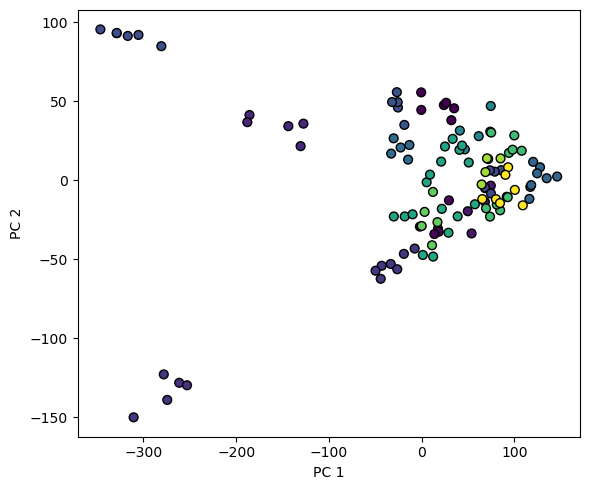

In [113]:
# km = KMeans(n_clusters=n_mol, n_init="auto", random_state=0).fit(test_pred)
labels_km = km.fit_predict(test_pred)
clusters = [i[0] for i in collections.Counter(labels_km).most_common(20)]
colors = ["red", "blue", "green", "yellow", "brown", "cyan", "pink"]
features = [] 
labels = [] 
color = [] 

i = 0 
for k in set(labels_km):

    if k not in clusters: continue 

    test_in_cluster = [test_ids[i].item() for i, l in enumerate(labels_km) if l ==k]
    if len(test_in_cluster) == 1: continue 

    test_labels = [dataset_info[dataset][str(t)]["inchikey_original"][:14] for t in test_in_cluster]
    features.extend([test_pred[i] for i, l in enumerate(labels_km) if l ==k])
    labels.extend(test_labels)
    color.extend([k for _ in range(len(test_labels))])
    i += 1 

pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(features)

fig, ax = plt.subplots(figsize=(6, 5))
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1],
                     c=color, s=40, edgecolor="k")
ax.set_xlabel("PC 1"); ax.set_ylabel("PC 2")

plt.tight_layout(); plt.show()

In [ ]:
# Done loading canopus
# Done loading MSG
# canopus binned_ random
# input PearsonRResult(statistic=np.float64(0.1781300960804217), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.37559748269400334), pvalue=np.float64(0.0))
# canopus binned_ inchikey_vanilla
# input PearsonRResult(statistic=np.float64(0.20822561241479864), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.21383850192747084), pvalue=np.float64(0.0))
# canopus binned_ scaffold_vanilla
# input PearsonRResult(statistic=np.float64(0.20329390010782974), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.21982855080245287), pvalue=np.float64(0.0))
# canopus binned_ LS
# input PearsonRResult(statistic=np.float64(0.16309512623477035), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.1465043695593178), pvalue=np.float64(0.0))
# canopus formula_ random
# input PearsonRResult(statistic=np.float64(0.1781300960804217), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.39710729612916934), pvalue=np.float64(0.0))
# canopus formula_ inchikey_vanilla
# input PearsonRResult(statistic=np.float64(0.20822561241479864), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.2714911791991324), pvalue=np.float64(0.0))
# canopus formula_ scaffold_vanilla
# input PearsonRResult(statistic=np.float64(0.20329390010782974), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.24072062209761264), pvalue=np.float64(0.0))
# canopus formula_ LS
# input PearsonRResult(statistic=np.float64(0.16309512623477035), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.155620802352916), pvalue=np.float64(0.0))
# canopus MS_ random
# input PearsonRResult(statistic=np.float64(0.1781300960804217), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.3750625699006677), pvalue=np.float64(0.0))
# canopus MS_ inchikey_vanilla
# input PearsonRResult(statistic=np.float64(0.20822561241479864), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.2834923874021293), pvalue=np.float64(0.0))
# canopus MS_ scaffold_vanilla
# input PearsonRResult(statistic=np.float64(0.20329390010782974), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.22504122450660563), pvalue=np.float64(0.0))
# canopus MS_ LS
# input PearsonRResult(statistic=np.float64(0.16309512623477035), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.148181252261618), pvalue=np.float64(0.0))
# canopus MIST_ random
# input PearsonRResult(statistic=np.float64(0.17389258630350013), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.7263290440886411), pvalue=np.float64(0.0))
# canopus MIST_ inchikey_vanilla
# input PearsonRResult(statistic=np.float64(0.19940097077063546), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.6154462275983268), pvalue=np.float64(0.0))
# canopus MIST_ scaffold_vanilla
# input PearsonRResult(statistic=np.float64(0.20284142497893834), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.5248840087725947), pvalue=np.float64(0.0))
# canopus MIST_ LS
# input PearsonRResult(statistic=np.float64(0.16309512623477035), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.48796077284298756), pvalue=np.float64(0.0))
# massspecgym binned_ random
# input PearsonRResult(statistic=np.float64(0.10420734269651696), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.2547762252226534), pvalue=np.float64(0.0))
# massspecgym binned_ inchikey_vanilla
# input PearsonRResult(statistic=np.float64(0.17458449734108172), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.17497650062239306), pvalue=np.float64(0.0))
# massspecgym binned_ scaffold_vanilla
# input PearsonRResult(statistic=np.float64(0.18852774066774758), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.17427623444313836), pvalue=np.float64(0.0))
# massspecgym binned_ LS
# input PearsonRResult(statistic=np.float64(0.039041862415863875), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.05753078526381257), pvalue=np.float64(0.0))
# massspecgym formula_ random
# input PearsonRResult(statistic=np.float64(0.10420734269651696), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.30459829641773445), pvalue=np.float64(0.0))
# massspecgym formula_ inchikey_vanilla
# input PearsonRResult(statistic=np.float64(0.17458449734108172), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.33927023938229495), pvalue=np.float64(0.0))
# massspecgym formula_ scaffold_vanilla
# input PearsonRResult(statistic=np.float64(0.18852774066774758), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.3355068659296257), pvalue=np.float64(0.0))
# massspecgym formula_ LS
# input PearsonRResult(statistic=np.float64(0.039041862415863875), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.1073060177743213), pvalue=np.float64(0.0))
# massspecgym MS_ random
# input PearsonRResult(statistic=np.float64(0.10420734269651696), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.27927053551864506), pvalue=np.float64(0.0))
# massspecgym MS_ inchikey_vanilla
# input PearsonRResult(statistic=np.float64(0.17458449734108172), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.1998687675380175), pvalue=np.float64(0.0))
# massspecgym MS_ scaffold_vanilla
# input PearsonRResult(statistic=np.float64(0.18852774066774758), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.19221483056987734), pvalue=np.float64(0.0))
# massspecgym MS_ LS
# input PearsonRResult(statistic=np.float64(0.039041862415863875), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.10906545336315508), pvalue=np.float64(0.0))
# massspecgym MIST_ random
# input PearsonRResult(statistic=np.float64(0.10420734269651753), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.6240298256734339), pvalue=np.float64(0.0))
# massspecgym MIST_ inchikey_vanilla
# input PearsonRResult(statistic=np.float64(0.17458449734108172), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.4923229023921402), pvalue=np.float64(0.0))
# massspecgym MIST_ scaffold_vanilla
# input PearsonRResult(statistic=np.float64(0.18852774066774947), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.49133094368299624), pvalue=np.float64(0.0))
# massspecgym MIST_ LS
# input PearsonRResult(statistic=np.float64(0.039041862415863875), pvalue=np.float64(0.0))
# prediction PearsonRResult(statistic=np.float64(0.4518952638814341), pvalue=np.float64(0.0))

: 